
<center>
<font color="cyan"><h2 >Parallelization.</h2></font>
</center>

<center>
<h3> Executing different nodes at same time.</h3>
</center>




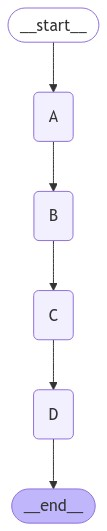

In [18]:
from langgraph.graph import START,END,StateGraph,MessagesState
from IPython.display import display, Image
from typing import TypedDict

# state
class State(TypedDict):
    # Reducer will append to messages. Look the parent class `MessagesState`
    state : str

# class based node.
class ReturnNodeValue:
    def __init__(self,node_message : str):
        self._value = node_message
    def __call__(self,state:State)-> any:
        print(f"Adding {self._value} in  : `{state['state']}` ")
        return {'state': self._value}


builder = StateGraph(State)
builder.add_node('A',ReturnNodeValue("I am node A"))
builder.add_node('B',ReturnNodeValue("I am node B"))
builder.add_node('C',ReturnNodeValue("I am node C"))
builder.add_node('D',ReturnNodeValue("I am node D"))
builder.add_edge(START,'A')
builder.add_edge('A','B')
builder.add_edge('B','C')
builder.add_edge('C','D')
builder.add_edge('D',END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

#### This is execuring perfectly fine. As this is simple without parallelization.

In [20]:
graph.invoke({'state':[]})

Adding I am node A in  : `[]` 
Adding I am node B in  : `I am node A` 
Adding I am node C in  : `I am node B` 
Adding I am node D in  : `I am node C` 


{'state': 'I am node D'}

### Now parallelization

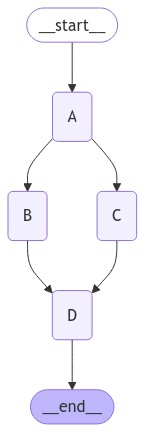

In [21]:
builder = StateGraph(State)
builder.add_node('A',ReturnNodeValue("I am node A"))
builder.add_node('B',ReturnNodeValue("I am node B"))
builder.add_node('C',ReturnNodeValue("I am node C"))
builder.add_node('D',ReturnNodeValue("I am node D"))
builder.add_edge(START,'A')
builder.add_edge('A','B')
builder.add_edge('A','C')
builder.add_edge('B','D')
builder.add_edge('C','D')
builder.add_edge('D',END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

 #### Error : At key 'state': Can receive only one value per step.

In [24]:
from langgraph.errors import InvalidUpdateError
try: 
    graph.invoke({'state':[]})
except InvalidUpdateError as e:
    print("Error : ",e)

Adding I am node A in  : `[]` 
Adding I am node B in  : `I am node A` 
Adding I am node C in  : `I am node A` 
Error :  At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


<p><strong>As at a time a state can receive only one update(as it replace the state value).If it receives more than one update then it's the developer job to handle how the updation should happen. Here comes the concept of reducer.</strong></p>

In [26]:
from typing import Annotated,TypedDict
import operator

class State(TypedDict):
    # operator.add is a reducer function. Which will add items to the list :  [] + 'sample exmaple'
    state : Annotated[list,operator.add]


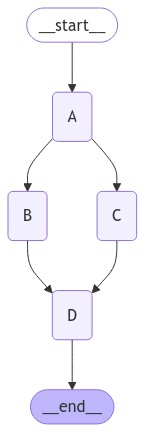

In [31]:
# class based node.
class ReturnNodeValue:
    def __init__(self,node_message : str):
        self._value = node_message
    def __call__(self,state:State)-> any:
        print(f"Adding [{self._value}] in  : `{state['state']}` ")
        return {'state': [self._value]}

builder = StateGraph(State)
builder.add_node('A',ReturnNodeValue("I am node A"))
builder.add_node('B',ReturnNodeValue("I am node B"))
builder.add_node('C',ReturnNodeValue("I am node C"))
builder.add_node('D',ReturnNodeValue("I am node D"))
builder.add_edge(START,'A')
builder.add_edge('A','B')
builder.add_edge('A','C')
builder.add_edge('B','D')
builder.add_edge('C','D')
builder.add_edge('D',END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
from langgraph.errors import InvalidUpdateError
try: 
    graph.invoke({'state':[]})
except InvalidUpdateError as e:
    print("Error : ",e)

Adding [I am node A] in  : `[]` 
Adding [I am node B] in  : `['I am node A']` 
Adding [I am node C] in  : `['I am node A']` 
Adding [I am node D] in  : `['I am node A', 'I am node B', 'I am node C']` 


#### While executing in parallel it graph execution wait for the all the paraller to be executed first then comes out of the parallelization and execute other node.
<p> In the below example we can see the output.</p>
<p><strong>Nodes running in parallel are the part of same step.</strong></p>
<ul>
<li>First A is executed.</li>
<li>Followed by B.</li>
<li>Followed by C.</li>
<li>Followed by D.</li>
<li>Followed by E.</li>
<li>Followed by E.</li>
</ul>
<p> E is being executed two times as call are coming from 2 branches.</p>

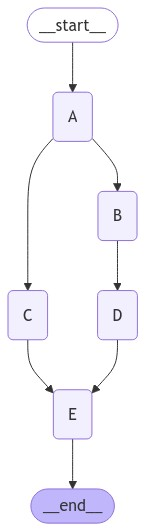

In [35]:
# class based node.
class ReturnNodeValue:
    def __init__(self,node_message : str):
        self._value = node_message
    def __call__(self,state:State)-> any:
        print(f"Adding [{self._value}] in  : `{state['state']}` ")
        return {'state': [self._value]}

builder = StateGraph(State)
builder.add_node('A',ReturnNodeValue("I am node A"))
builder.add_node('B',ReturnNodeValue("I am node B"))
builder.add_node('C',ReturnNodeValue("I am node C"))
builder.add_node('D',ReturnNodeValue("I am node D"))
builder.add_node('E',ReturnNodeValue("I am node E"))
builder.add_edge(START,'A')
builder.add_edge('A','B')
builder.add_edge('A','C')
builder.add_edge('B','D')
builder.add_edge('C','E')
builder.add_edge('D','E')
builder.add_edge('E',END)


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
graph.invoke({'state':[]})

Adding [I am node A] in  : `[]` 
Adding [I am node B] in  : `['I am node A']` 
Adding [I am node C] in  : `['I am node A']` 
Adding [I am node D] in  : `['I am node A', 'I am node B', 'I am node C']` 
Adding [I am node E] in  : `['I am node A', 'I am node B', 'I am node C']` 
Adding [I am node E] in  : `['I am node A', 'I am node B', 'I am node C', 'I am node D', 'I am node E']` 


{'state': ['I am node A',
  'I am node B',
  'I am node C',
  'I am node D',
  'I am node E',
  'I am node E']}